In [53]:
# Import necessary libraries
from sklearn.datasets import fetch_lfw_people  # for loading the LFW dataset
from sklearn.model_selection import train_test_split  # for splitting data into train and test sets
from sklearn.decomposition import PCA  # for dimensionality reduction (PCA from sklearn)
from sklearn.svm import SVC  # Support Vector Machine classifier
from sklearn.metrics import classification_report, confusion_matrix  # for model evaluation

import matplotlib.pyplot as plt  # for visualization
import numpy as np  # for numerical operations
import seaborn as sns  # for creating heatmaps


In [54]:
# Load the LFW people dataset with a minimum of 80 faces per person
data = fetch_lfw_people(min_faces_per_person=80)

In [55]:
# Print the shape of the image data (number of images, height, width)
print(data.images.shape)


(1140, 62, 47)


In [56]:
# Extract the number of images, height, and width of each image
_, h, w = data.images.shape

In [57]:
# Extract the features (pixel values)
X = data.data
X.shape

(1140, 2914)

In [58]:
# Extract the target labels (person IDs)
y = data.target
y.shape


(1140,)

In [59]:
# Get the names of the people in the dataset
target_names = data.target_names

Colin Powell


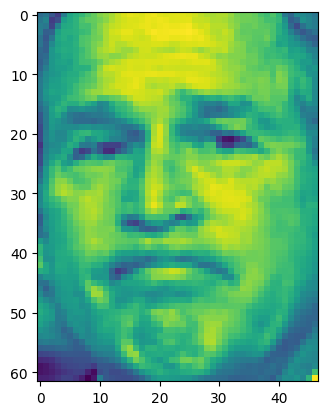

In [60]:
# Visualize the first image and print its corresponding person's name
plt.imshow(data.images[0])
print(data.target_names[0])

In [61]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Print the shapes of the training and testing sets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(912, 2914)
(912,)
(228, 2914)
(228,)


In [62]:
# Custom PCA implementation
class MyPCA:

    def __init__(self, n_components):
        self.n_components = n_components

    def fit(self, X):
        # Standardize data
        X = X.copy()
        self.mean = np.mean(X, axis=0)
        self.scale = np.std(X, axis=0)
        X_std = (X - self.mean) / self.scale

        # Eigendecomposition of covariance matrix
        cov_mat = np.cov(X_std.T)
        eig_vals, eig_vecs = np.linalg.eig(cov_mat)

        # Adjusting eigenvectors to be positive
        max_abs_idx = np.argmax(np.abs(eig_vecs), axis=0)
        signs = np.sign(eig_vecs[max_abs_idx, range(eig_vecs.shape[0])])
        eig_vecs = eig_vecs * signs[np.newaxis, :]
        eig_vecs = eig_vecs.T

        # Sort eigenpairs by decreasing eigenvalue magnitude
        eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[i, :]) for i in range(len(eig_vals))]
        eig_pairs.sort(key=lambda x: x[0], reverse=True)
        eig_vals_sorted = np.array([x[0] for x in eig_pairs])
        eig_vecs_sorted = np.array([x[1] for x in eig_pairs])

        # Select top n_components eigenvectors as principal components
        self.components = eig_vecs_sorted[: self.n_components, :]

        # Explained variance ratio and cumulative explained variance
        self.explained_variance_ratio = [i / np.sum(eig_vals) for i in eig_vals_sorted[: self.n_components]]
        self.cum_explained_variance = np.cumsum(self.explained_variance_ratio)

        return self

    def transform(self, X):
        X = X.copy()
        X_std = (X - self.mean) / self.scale
        X_proj = X_std.dot(self.components.T)  # Project data onto principal components

        return X_proj

# Perform PCA using the custom implementation with 100 components
my_pca = MyPCA(n_components=100).fit(X)

print("Components:\n", my_pca.components)
#print("Explained variance ratio from scratch:\n", my_pca.explained_variance_ratio)
#print("Cumulative explained variance from scratch:\n", my_pca.cum_explained_variance)

# Transform training and testing data using the custom PCA
X_train_pca = my_pca.transform(X_train)
X_test_pca = my_pca.transform(X_test)

print("Transformed data shape from scratch:", X_train_pca.shape)


Components:
 [[ 0.00575126+0.j  0.00650723+0.j  0.00737965+0.j ...  0.00444484+0.j
   0.00402297+0.j  0.00334535+0.j]
 [-0.01378572+0.j -0.01322047+0.j -0.01312777+0.j ...  0.01021029-0.j
   0.01023441-0.j  0.01037265-0.j]
 [ 0.0205579 -0.j  0.02232033-0.j  0.02433498-0.j ...  0.00376269-0.j
   0.00337916-0.j  0.00247666-0.j]
 ...
 [-0.01546607+0.j -0.01436902+0.j -0.00878153+0.j ... -0.01776588+0.j
  -0.02010875+0.j -0.01518517+0.j]
 [-0.05483514+0.j -0.06135392+0.j -0.05453989+0.j ...  0.00261057+0.j
   0.01868345+0.j  0.03274324+0.j]
 [-0.02159718+0.j -0.0242428 +0.j -0.01714691+0.j ...  0.01146715-0.j
  -0.00687324+0.j -0.02642662+0.j]]
Transformed data shape from scratch: (912, 100)


In [63]:
# Reshape the principal components to visualize eigenfaces
eigenfaces = my_pca.components.reshape((100, h, w))

In [64]:
# Cast to float32 for visualization purposes (avoid complex warnings)
X_train_pca = X_train_pca.astype(np.float64)
X_test_pca = X_test_pca.astype(np.float64)

<ipython-input-64-07e9de2eac68>:2: ComplexWarning: Casting complex values to real discards the imaginary part
  X_train_pca = X_train_pca.astype(np.float64)
<ipython-input-64-07e9de2eac68>:3: ComplexWarning: Casting complex values to real discards the imaginary part
  X_test_pca = X_test_pca.astype(np.float64)


In [65]:
# Get the number of unique classes (individuals) in the test set
num_classes = len(np.unique(y_test))
print(f"Number of classes: {num_classes}")

Number of classes: 5


In [66]:
# Train an SVM classifier on the lower-dimensional training data
clf1 = SVC()
clf1 = clf1.fit(X_train_pca, y_train)

In [67]:
# Predict the labels of the test set
y_pred1 = clf1.predict(X_test_pca)
y_pred1.shape

(228,)

In [68]:
# Evaluate the performance of the SVM classifier
print(classification_report(y_test, y_pred1, labels=np.unique(y_test), target_names=target_names))


                   precision    recall  f1-score   support

     Colin Powell       0.92      0.84      0.88        57
  Donald Rumsfeld       0.91      0.53      0.67        19
    George W Bush       0.74      0.98      0.85       101
Gerhard Schroeder       0.60      0.29      0.39        21
       Tony Blair       0.82      0.60      0.69        30

         accuracy                           0.79       228
        macro avg       0.80      0.65      0.69       228
     weighted avg       0.80      0.79      0.78       228



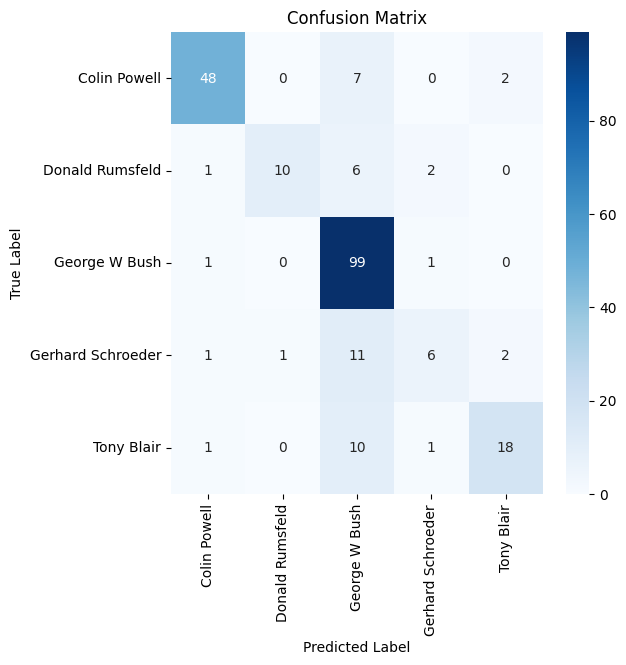

In [69]:
# Create a confusion matrix to visualize the classification results
cm = confusion_matrix(y_test, y_pred1)
plt.figure(figsize=(6, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=target_names,
    yticklabels=target_names,
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [70]:
# Get the size of the target_names list (should match the number of classes)
num_target_names = len(target_names)
print(f"Size of target_names list: {num_target_names}")

Size of target_names list: 5


In [71]:
# Function to plot a gallery of portraits
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

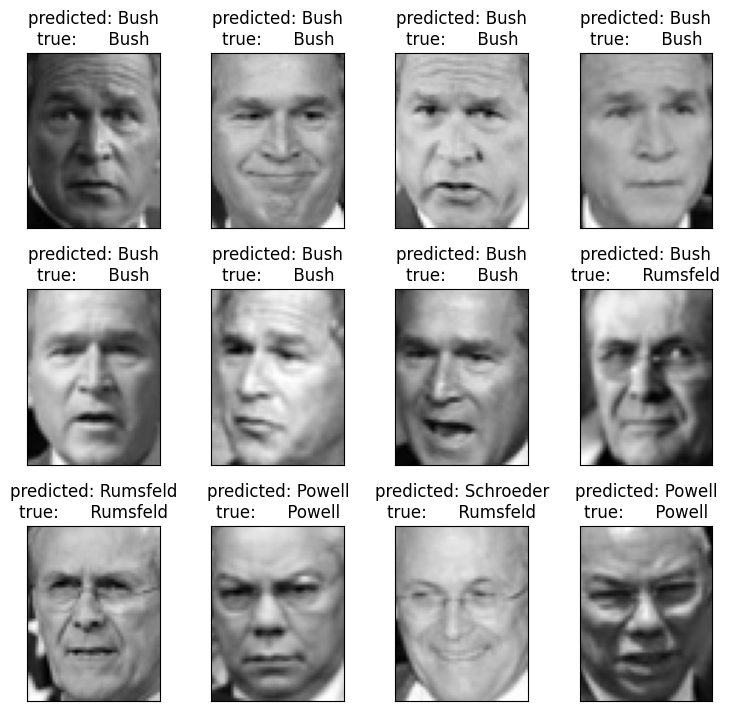

In [72]:
# Function to generate titles for predicted images
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)


# Create titles for predicted images
prediction_titles = [title(y_pred1, y_test, target_names, i) for i in range(y_pred1.shape[0])]

# Plot a gallery of test images with predicted and true labels
plot_gallery(X_test, prediction_titles, h, w)

<ipython-input-73-7fc6416ad325>:2: ComplexWarning: Casting complex values to real discards the imaginary part
  eigenfaces = eigenfaces.astype(np.float32)


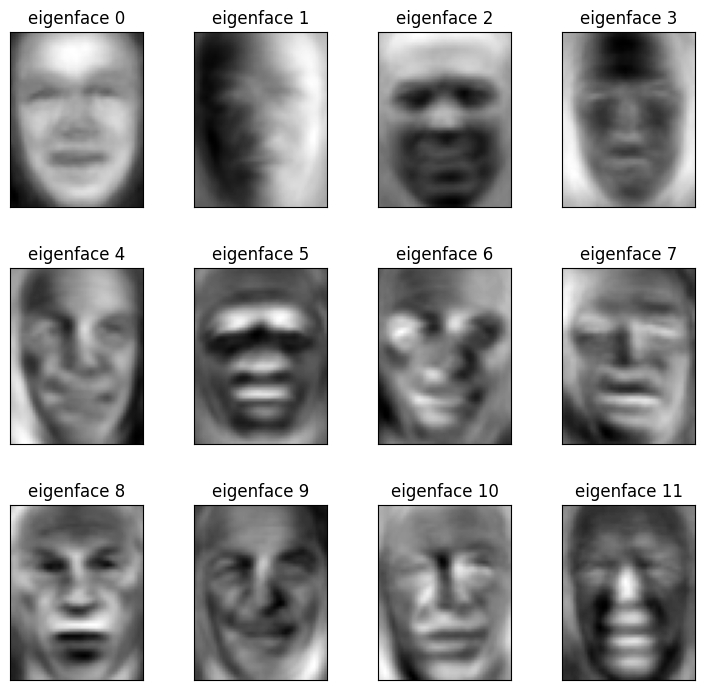

In [73]:
# Cast eigenfaces to float32 for visualization purposes
eigenfaces = eigenfaces.astype(np.float32)

# Create titles for eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]

# Plot a gallery of eigenfaces
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()